In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Projection function to ensure the norm of x does not exceed the given radius
def projection_func(x, radius):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return x  # Return x unchanged if its norm is 0
    if norm_x > radius:
        x = (radius / norm_x) * x
    return x
    
# Gradient of f(x)
def grad_f(x, A, a):
    # The gradient of f(x) = A x + a
    return np.dot(A, x) + a

# Function h(x) = f(x) / g(x)
def h(x, A, a, alpha, b, beta):
    return f(x, A, a, alpha) / g(x, b, beta)

# Gradient of h(x)
def grad_h(x, A, a, alpha, b, beta):
    # Precompute g(x) and h(x) to avoid redundant calculations
    g_x = g(x, b, beta)
    h_x = h(x, A, a, alpha, b, beta)
    
    # Gradient of f divided by g(x)
    grad_f_term = grad_f(x, A, a) / g_x
    
    # Gradient of the denominator g(x) = b
    grad_g_term = (h_x / g_x) * b
    
    # Apply the quotient rule: (grad_f_term - grad_g_term) / g(x)
    return grad_f_term - grad_g_term
# Gradient approximation of h(x)
def grad_hzo(x, A, a, alpha, b, beta,step):
    dimzo=len(initial_point)
    identity_matrix=np.eye(dimzo)
    grad = np.zeros_like(x)
    h_x = h(x, A, a, alpha, b, beta)
    for i in range(dimzo):
     e_i = identity_matrix[i,:]
     h_i = h(x+step*e_i, A, a, alpha, b, beta)
     grad+= ((h_i-h_x) / step)*e_i
    return grad
# Function f(x)
def f(x, A, a, alpha):
    return 0.5 * np.dot(x, np.dot(A, x)) + np.dot(a, x) + alpha

# Function g(x)
def g(x, b, beta):
    return np.dot(b, x) + beta
def create_positive_definite_matrix(n, m, a_1):
    """
    Create an n x n positive definite matrix A with eigenvalues lower bounded by a_1.
    
    Parameters:
    - n: Dimension of the matrix.
    - a_1: Lower bound for the eigenvalues of A.
    
    Returns:
    - A: Positive definite matrix with eigenvalues >= a_1.
    """
    # Create a random n x n matrix
    random_matrix = np.random.randn(m, n)
    
    # Symmetrize the matrix to ensure it's symmetric
    symmetric_matrix = np.dot(random_matrix.T, random_matrix)
    
    # Add a_1 * I to ensure eigenvalues are bounded below by a_1
    A = a_1*symmetric_matrix + a_1 * np.eye(n)
    norm_A = np.linalg.norm(A, ord=2)
    return A / norm_A

# Function to compute the Lipschitz constant L
def compute_L(norm_A, norm_a, alpha, norm_b, R, m):
    # First term: ||A||^2 / m
    term1 = (norm_A**2) / m
    
    # Second term: 2 * ||b|| * (||A|| * ||x|| + ||a||) / m^2
    term2 = 2 * norm_b * (norm_A * R + norm_a) / (m**2)
    
    # Third term: (1/2 * ||A|| * ||x||^2 + ||a|| * ||x|| + alpha) * ||b||^2 / m^3
    term3 = ((0.5 * norm_A * (R**2) + norm_a * R + alpha) * norm_b**2)    #/ (m**3)
    
    # Total L
    L =  term1 + term2 + term3
    
    return L

# Function to generate a vector b of norm R
def gen_b(R, n):
    # Generate a random n-dimensional vector
    b_old = np.random.randn(n)
    
    # Compute the norm of b_old
    norm_b_old = np.linalg.norm(b_old)
    8
    # Avoid division by zero
    if norm_b_old == 0:
        return np.zeros_like(b_old)
    
    # Normalize b_old and scale by R
    b = R * (b_old / norm_b_old)
    return b

def gen_b_new(b, t, R, n):
    """
    Generate a new vector b, perturbed slightly with Gaussian noise.
    
    Parameters:
    - b: Initial vector.
    - t: Current iteration or time step (used for scaling the noise).
    - R: Scaling factor for the final vector.
    - n: Dimension of the vector.
    
    Returns:
    - b: New perturbed and normalized vector scaled by R.
    """
    # Generate a perturbed version of b
    b_old = b + (0.01 / np.sqrt(t)) * np.random.randn(n)
    
    # Compute the norm of b_old
    norm_b_old = np.linalg.norm(b_old)
    
    # Avoid division by zero by returning the zero vector if the norm is zero
    if norm_b_old == 0:
        return np.zeros_like(b_old)
    
    # Normalize b_old and scale by R
    b_new = R * (b_old / norm_b_old)
    return b_new

def create_positive_definite_matrix_new(A, t, n, m, a_1):
    """
    Create an n x n positive definite matrix with eigenvalues lower bounded by a_1.
    
    Parameters:
    - A: Existing matrix to be perturbed.
    - t: Current iteration or time step (used for scaling).
    - n: Dimension of the matrix.
    - m: The number of rows for generating a random matrix.
    - a_1: Lower bound for the eigenvalues of A.
    
    Returns:
    - A_new: A new positive definite matrix with eigenvalues >= a_1.
    """
    # Generate a random m x n matrix
    random_matrix = np.random.randn(m, n)
    
    # Symmetrize the matrix to ensure it's symmetric and positive semi-definite
    symmetric_matrix = np.dot(random_matrix.T, random_matrix)
    
    # Add a_1 * I to ensure eigenvalues are bounded below by a_1
    A_new = A +(0.01 / np.sqrt(t)) * (a_1 * symmetric_matrix + a_1 * np.eye(n))
    
    # Normalize A to keep the norm bounded
    norm_A_new = np.linalg.norm(A_new, ord=2)
    
    return A_new / norm_A_new


In [3]:
def subroutine(grad_h, projection_func, eta, max_iterations, initial_point, radius, tol,A,a,b,alpha,beta, norm_A,norm_a,norm_b):
   
    # Initialize the point and regret tracking
    x = initial_point.copy()
    x_old = x.copy()
    error = 1e10
    iter = 0
    x_sol=x.copy()
    # while error>tol or iter<max_iterations:
    while  error>tol :
        iter = iter + 1
        # Compute the gradient at the current point
        grad = grad_h(x, A, a, alpha, b, beta)
        x_old = x.copy()
        # Gradient descent update step
        x = x - eta * grad

        # Projection step to ensure the updated point is within the feasible set
        # x = projection_func(x, radius)
        # if  h(x_sol, A, a, alpha, b, beta)> h(x, A, a, alpha, b, beta):
        #     x_sol=x.copy()
        error = np.linalg.norm(x-x_old) /np.linalg.norm(x)  
    return x

In [4]:
def online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,max_delay,tol,dim,M,m, norm_b, norm_a, norm_A, grad_hzo, factor,expo,expo1,expo2,expo3,A_all,a_all,b_all,sol_all):
    """
    Online Delayed Projected Gradient Descent Algorithm.

    Parameters:
    - grad_h: function to compute the gradient of the objective function.
    - projection_func: function to project the point back to the feasible set.
    - eta: the learning rate or step size for the gradient descent update.
    - num_iterations: number of iterations to run the algorithm.
    - initial_point: starting point for the algorithm.
    - radius: radius of the feasible set.
    - vec_delays: list of delays indicating when gradients arrive.

    Returns:
    - regret_values: array of cumulative regret values at each iteration.
    """

    # Initialize the point, regret tracking, and storage for x values
    x = np.zeros(dim)
    xzo = np.zeros(dim)
    xzo1 = np.zeros(dim)
    xzo2 = np.zeros(dim)
    xzo3 = np.zeros(dim)
    cumulative_regret = 0
    cumulative_regretzo = 0
    cumulative_regretzo1 = 0
    cumulative_regretzo2= 0
    cumulative_regretzo3= 0
    regret_values = np.zeros(num_iterations)
    regret_valueszo = np.zeros(num_iterations)
    regret_valueszo1 = np.zeros(num_iterations)
    regret_valueszo2 = np.zeros(num_iterations)
    regret_valueszo3 = np.zeros(num_iterations)
    vec_iter = np.zeros((len(initial_point), num_iterations))
    vec_iterzo = np.zeros((len(initial_point), num_iterations))
    vec_iterzo1 = np.zeros((len(initial_point), num_iterations))
    vec_iterzo2 = np.zeros((len(initial_point), num_iterations))
    vec_iterzo3 = np.zeros((len(initial_point), num_iterations))
    m = 100
    beta = m+norm_b*radius
    alpha = 10
    M = norm_b*radius+beta
    kappa = m / M
    L = compute_L(norm_A, norm_a, alpha, norm_b, radius, m)
    max_iterations = 1e8
    # Step-size
    eta = 0.99*(kappa / L)/ (max_delay+4*np.sqrt(max_delay)*(max_delay-1))
    eta1 =0.99*(kappa / L)
    for t in range(num_iterations):
        grad = np.zeros_like(x)  # Initialize gradient to zero for each iteration
        gradzo = np.zeros_like(xzo)  # Initialize gradient to zero for each iteration
        gradzo1 = np.zeros_like(xzo1)  # Initialize gradient to zero for each iteration
        gradzo2 = np.zeros_like(xzo2)  # Initialize gradient to zero for each iteration
        gradzo3 = np.zeros_like(xzo3)  # Initialize gradient to zero for each iteration
        vec_iter[:, t] = x  # Store the current point x in vec_iter
        vec_iterzo[:, t] = xzo  # Store the current point x in vec_iter
        vec_iterzo1[:, t] = xzo1  # Store the current point x in vec_iter
        vec_iterzo2[:, t] = xzo2 # Store the current point x in vec_iter
        vec_iterzo3[:, t] = xzo3 # Store the current point x in vec_iter

        # Process delayed gradients that arrive at this time step
        for j in vec_delays[t]:
            # Update the cumulative regret and store its value
            # cumulative_regret += max((h(x, A, a, alpha, b, beta)-h(sol_t, A, a, alpha, b, beta)),0)
            A = A_all[j]
            b = b_all[j]
            a = a_all[j]
            sol_t = sol_all[j]
            x_old = vec_iter[:, j].copy()
            x_oldzo = vec_iterzo[:, j].copy()
            x_oldzo1 = vec_iterzo1[:, j].copy()
            x_oldzo2 = vec_iterzo2[:, j].copy()
            x_oldzo3 = vec_iterzo3[:, j].copy()
            h_x =  h(sol_t, A, a, alpha, b, beta)
            h_x1 = h(x_old, A, a, alpha, b, beta)
            h_x2 = h(x_oldzo, A, a, alpha, b, beta)
            h_x3 = h(x_oldzo1, A, a, alpha, b, beta)
            h_x4 = h(x_oldzo2, A, a, alpha, b, beta) 
            h_x5 = h(x_oldzo3, A, a, alpha, b, beta) 
            if  h_x> h_x1:
                sol_t=x_old.copy()
                h_x =  h_x1
            if  h_x> h_x2:
                sol_t=x_oldzo.copy()
                h_x =  h_x2
            if  h_x> h_x3:
                sol_t=x_oldzo1.copy()
                h_x =  h_x3
            if  h_x> h_x4:
                sol_t=x_oldzo2.copy()
                h_x =  h_x4
            if  h_x> h_x5:
                sol_t=x_oldzo3.copy()
                h_x =  h_x5
            # Compute the delayed gradient at the stored point
            # Compute the delayed gradient at the stored point
            grad += grad_h(x_old, A, a, alpha, b, beta)
            gradzo += grad_hzo(x_oldzo, A, a, alpha, b, beta, (factor / ((t+1)**expo)))
            gradzo1 += grad_hzo(x_oldzo1, A, a, alpha, b, beta, (factor / ((t+1)**expo1)))
            gradzo2 += grad_hzo(x_oldzo2, A, a, alpha, b, beta, (factor / ((t+1)**expo2)))
            gradzo3 += grad_hzo(x_oldzo3, A, a, alpha, b, beta, (factor / ((t+1)**expo3)))
            
            # Update the regret value based on the delayed information
            regret_values[j] = (h_x1-h_x)
            regret_valueszo[j] = (h_x2-h_x)
            regret_valueszo1[j] = (h_x3-h_x)
            regret_valueszo2[j] = (h_x4-h_x)
            regret_valueszo3[j] = (h_x5-h_x)

        # print(iter)
        # Gradient descent update step using the accumulated gradient
        x = x - eta * grad
        xzo = xzo - eta * gradzo
        xzo1 = xzo1 - eta * gradzo1
        xzo2 = xzo2 - eta * gradzo2
        xzo3 = xzo3 - eta* gradzo3

        # Projection step to ensure the updated point is within the feasible set
        xzo = projection_func(xzo, radius)
        xzo1 = projection_func(xzo1, radius)
        xzo2 = projection_func(xzo2, radius)
        xzo3 = projection_func(xzo3, radius)
        x = projection_func(x, radius)
    for kkk in range(num_iterations):
        # Update the cumulative regret and store its value
        cumulative_regret += regret_values[kkk]
        regret_values[kkk] = cumulative_regret.copy()
        cumulative_regretzo += regret_valueszo[kkk]
        regret_valueszo[kkk] = cumulative_regretzo.copy()
        cumulative_regretzo1 += regret_valueszo1[kkk]
        regret_valueszo1[kkk] = cumulative_regretzo1.copy()
        cumulative_regretzo2 += regret_valueszo2[kkk]
        regret_valueszo2[kkk] = cumulative_regretzo2.copy()
        cumulative_regretzo3 += regret_valueszo3[kkk]
        regret_valueszo3[kkk] = cumulative_regretzo3.copy()

    return regret_values, regret_valueszo, regret_valueszo1, regret_valueszo2, regret_valueszo3

In [14]:
def plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, dim, max_delay, tol,M,m, norm_b, norm_a, norm_A, grad_hzo, factor,expo,expo1,expo2,expo3):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    regret_valueszo = np.zeros((num_iterations, cases))
    regret_valueszo1 = np.zeros((num_iterations, cases))
    regret_valueszo2 = np.zeros((num_iterations, cases))
    regret_valueszo3 = np.zeros((num_iterations, cases))
    eta = 0.99*(kappa / L)/ (delay+4*np.sqrt(delay)*(delay-1))
    eta1 = 0.99*(kappa / L)
    # Running the algorithm for each case
    for i in range(cases):
        print(i)
        A = create_positive_definite_matrix(dim, dim, 1)
        b = gen_b(norm_b, dim)
        a = gen_b(norm_a, dim )
        sol_t = subroutine(grad_h, projection_func, eta1, num_iterations, np.zeros(dim), radius,tol,A,a,b,alpha,beta,norm_A,norm_a,norm_b)
        A_all = []
        a_all = []
        b_all = []
        sol_all = []
        # Populate vec_delays with the delayed indices
        for tttt in range(num_iterations):
                A = create_positive_definite_matrix_new(A,t+1,dim, dim, 1)
                b = gen_b_new(b,tttt+1,norm_b, dim)
                a = gen_b_new(a,tttt+1,norm_a, dim )
                sol_t = subroutine(grad_h, projection_func, eta1, num_iterations, sol_t, radius, tol,A,a,b,alpha,beta,norm_A,norm_a,norm_b)
                A_all.append(A)
                a_all.append(a)
                b_all.append(b)
                sol_all.append(sol_t)
        delays = np.random.randint(1, max_delay+1, size=(num_iterations, 1))
        # Initialize vec_delays as a list of empty lists
        vec_delays = [[] for _ in range(num_iterations + max_delay)]
        # Populate vec_delays with the delayed indices
        for jjj in range(num_iterations):
            vec_delays[jjj + int(delays[jjj]) - 1].append(jjj)
        initial_point = np.zeros(dim)        # Normalize the vector to have unit norm
        r1,r2,r3,r4,r5 = online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,max_delay,tol,dim,M,m, norm_b, norm_a, norm_A, grad_hzo, factor, expo,expo1,expo2, expo3, A_all,a_all,b_all,sol_all)
        regret_values[:, i] = r1.copy()
        regret_valueszo[:, i] = r2.copy()
        regret_valueszo1[:, i] = r3.copy()
        regret_valueszo2[:, i] = r4.copy()
        regret_valueszo3[:, i] = r5.copy()
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    std_regret = np.std(regret_values, axis=1)
    mean_regretzo = np.mean(regret_valueszo, axis=1)
    std_regretzo = np.std(regret_valueszo, axis=1)
    mean_regretzo1 = np.mean(regret_valueszo1, axis=1)
    std_regretzo1 = np.std(regret_valueszo1, axis=1)
    mean_regretzo2 = np.mean(regret_valueszo2, axis=1)
    std_regretzo2 = np.std(regret_valueszo2, axis=1)
    mean_regretzo3 = np.mean(regret_valueszo3, axis=1)
    std_regretzo3 = np.std(regret_valueszo3, axis=1)


    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))
    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Full gradient', color= 'aqua', lw=2)
    plt.plot(iterations, mean_regretzo, label='a=1', color= 'maroon', linestyle='--')
    plt.plot(iterations, mean_regretzo1, label='a=0.75', color= 'fuchsia', linestyle='--')
    plt.plot(iterations, mean_regretzo2, label='a=0.5', color= 'orange', linestyle='--')
    plt.plot(iterations, mean_regretzo3, label='a=0.25', color= 'green', linestyle='--')
    plt.legend(loc='best',fontsize='small')

    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color='aqua', alpha=0.2)
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regretzo - std_regretzo, mean_regretzo + std_regretzo, 
                     color='maroon', alpha=0.2)
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regretzo1 - std_regretzo1, mean_regretzo1 + std_regretzo1, 
                     color='fuchsia', alpha=0.2)
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regretzo2 - std_regretzo2, mean_regretzo2 + std_regretzo2, 
                     color='orange', alpha=0.2)
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regretzo3 - std_regretzo3, mean_regretzo3 + std_regretzo3, 
                     color='green', alpha=0.2)
    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('delayedzo123456.jpeg')
    plt.show()
    return regret_values, regret_valueszo, regret_valueszo1, regret_valueszo2

In [6]:
# Parameters
num_iterations = 20000
radius = 10
dim = 50
m = 100
# Calculate norms
norm_A = 1  # ||A||
norm_b = 0.1  # ||b||
norm_a = 0.1  # ||a||
beta = m+norm_b*radius
alpha = 10
tol = 1e-6
M = norm_b*radius+beta
kappa = m / M
delay = 10
initial_point = np.zeros(dim)
L = compute_L(norm_A, norm_a, alpha, norm_b, radius, m)
eta = 0.99*(kappa / L)
A = create_positive_definite_matrix(dim, dim, 1)
b = gen_b(norm_b, dim)
a = gen_b(norm_a, dim )
sol_t = subroutine(grad_h, projection_func, eta, num_iterations, np.zeros(dim), radius,tol,A,a,b,alpha,beta,norm_A,norm_a,norm_b)
A_all = []
a_all = []
b_all = []
sol_all = []
# Populate vec_delays with the delayed indices
for t in range(num_iterations):
    print(t)
    A = create_positive_definite_matrix_new(A,t+1,dim, dim, 1)
    b = gen_b_new(b,t+1,norm_b, dim)
    a = gen_b_new(a,t+1,norm_a, dim )
    sol_t = subroutine(grad_h, projection_func, eta, num_iterations, sol_t, radius, tol,A,a,b,alpha,beta,norm_A,norm_a,norm_b)
    A_all.append(A)
    a_all.append(a)
    b_all.append(b)
    sol_all.append(sol_t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
delays = np.random.randint(1, t+1, size=(num_iterations, 1))
# Initialize vec_delays as a list of empty lists
vec_delays = [[] for _ in range(num_iterations + t)]
# Populate vec_delays with the delayed indices
for jjj in range(num_iterations):
    vec_delays[jjj + int(delays[jjj]) - 1].append(jjj)

C:\Users\cris_\AppData\Local\Temp\ipykernel_9320\2833646436.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[jjj + int(delays[jjj]) - 1].append(jjj)


In [8]:
# Parameters
num_iterations = 20000
radius = 10
dim = 50
m = 100
# Calculate norms
norm_A = 1  # ||A||
norm_b = 0.1  # ||b||
norm_a = 0.1  # ||a||
beta = m+norm_b*radius
alpha = 10
tol = 1e-6
M = norm_b*radius+beta
kappa = m / M
delay = 10
factor = 1
expo = 1
expo1 = 0.75
expo2 = 0.625
expo3 = 0.5
initial_point = np.zeros(dim)
L = compute_L(norm_A, norm_a, alpha, norm_b, radius, m)
eta = 0.99*(kappa / L)/ (delay+4*np.sqrt(delay)*(delay-1))
online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,delay,tol,dim,M,m, norm_b, norm_a, norm_A, grad_hzo, factor,expo,expo1,expo2, expo3,A_all,a_all,b_all,sol_all)

(array([2.96288772e-04, 4.99096350e-04, 6.60991346e-04, ...,
        4.83595061e-01, 4.83595061e-01, 4.83595061e-01]),
 array([2.96288772e-04, 4.99096350e-04, 6.60991346e-04, ...,
        4.83710124e-01, 4.83710124e-01, 4.83710124e-01]),
 array([2.96288772e-04, 4.99096350e-04, 6.60991346e-04, ...,
        4.84542452e-01, 4.84542452e-01, 4.84542452e-01]),
 array([2.96288772e-04, 4.99096350e-04, 6.60991346e-04, ...,
        4.86631574e-01, 4.86631574e-01, 4.86631574e-01]),
 array([2.96288772e-04, 4.99096350e-04, 6.60991346e-04, ...,
        4.95440556e-01, 4.95440556e-01, 4.95440556e-01]))

0


C:\Users\cris_\AppData\Local\Temp\ipykernel_9320\2896729534.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[jjj + int(delays[jjj]) - 1].append(jjj)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


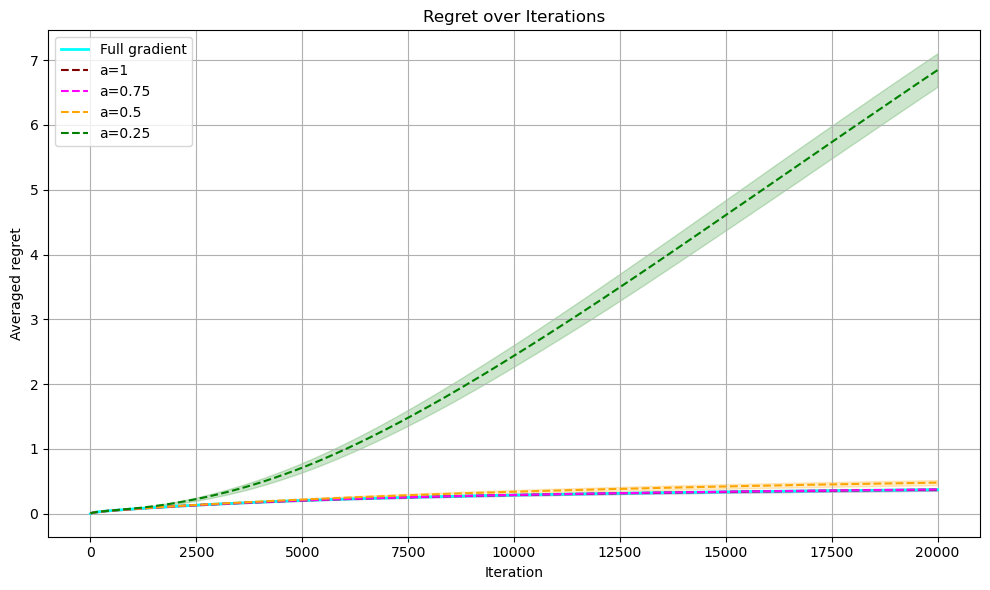

In [15]:
# Parameters
num_iterations = 20000
radius = 10
dim = 50
m = 100
# Calculate norms
norm_A = 1  # ||A||
norm_b = 0.1  # ||b||
norm_a = 0.1  # ||a||
beta = m+norm_b*radius
alpha = 10
tol = 1e-6
M = norm_b*radius+beta
kappa = m / M
delay = 10
factor = 1
expo = 1
expo1 = 0.75
expo2 = 0.5
expo3 = 0.25
initial_point = np.zeros(dim)
L = compute_L(norm_A, norm_a, alpha, norm_b, radius, m)
eta = 0.99*(kappa / L)/ (delay+4*np.sqrt(delay)*(delay-1))
cases = 20
regret_values, regret_valueszo, regret_valueszo1, regret_valueszo2 = plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, dim, delay, tol,M,m, norm_b, norm_a, norm_A, grad_hzo, factor,expo,expo1,expo2,expo3)

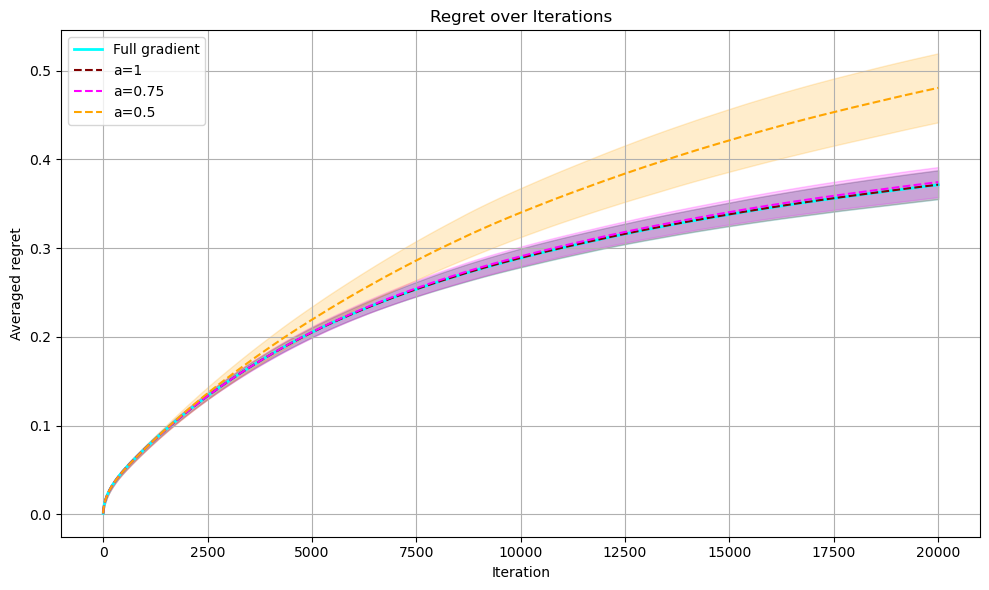

In [18]:
# Compute mean and standard deviation for plotting shaded regions
iterations = np.arange(1, num_iterations + 1)
mean_regret = np.mean(regret_values, axis=1)
std_regret = np.std(regret_values, axis=1)
mean_regretzo = np.mean(regret_valueszo, axis=1)
std_regretzo = np.std(regret_valueszo, axis=1)
mean_regretzo1 = np.mean(regret_valueszo1, axis=1)
std_regretzo1 = np.std(regret_valueszo1, axis=1)
mean_regretzo2 = np.mean(regret_valueszo2, axis=1)


# Plot of regret values over iterations
plt.figure(figsize=(10, 6))
# Plot the mean regret line
plt.plot(iterations, mean_regret, label='Full gradient', color= 'aqua', lw=2)
plt.plot(iterations, mean_regretzo, label='a=1', color= 'maroon', linestyle='--')
plt.plot(iterations, mean_regretzo1, label='a=0.75', color= 'fuchsia', linestyle='--')
plt.plot(iterations, mean_regretzo2, label='a=0.5', color= 'orange', linestyle='--')
plt.legend(loc='best',fontsize='small')

# Plot shaded area (mean ± std_dev)
plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color='aqua', alpha=0.2)
# Plot shaded area (mean ± std_dev)
plt.fill_between(iterations, mean_regretzo - std_regretzo, mean_regretzo + std_regretzo, 
                     color='maroon', alpha=0.2)
# Plot shaded area (mean ± std_dev)
plt.fill_between(iterations, mean_regretzo1 - std_regretzo1, mean_regretzo1 + std_regretzo1, 
                     color='fuchsia', alpha=0.2)
# Plot shaded area (mean ± std_dev)
plt.fill_between(iterations, mean_regretzo2 - std_regretzo2, mean_regretzo2 + std_regretzo2, 
                      color='orange', alpha=0.2)
    # Add labels and grid
plt.title('Regret over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Averaged regret')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('delayedzo123456.jpeg')
plt.show()

In [11]:
print(np.linalg.norm(mean_regret-mean_regretzo))

0.02308808614565562


In [12]:
print(np.sum(mean_regret>mean_regretzo))
print(std_regretzo[19999:20000])
print(std_regret[19999:20000])
print(std_regretzo1[19999:20000])
print(std_regretzo2[19999:20000])

270
[0.0153052]
[0.01507655]
[0.01662614]
[0.03219458]


In [13]:
tol=1e-6
vec_error= np.zeros(num_iterations)
vec_error[0] = mean_regretzo2[0]
for i in range(num_iterations-1):
        vec_error[i+1]=(mean_regretzo2[i+1]-mean_regretzo2[i])
count=0
while vec_error[count]>tol:
        count=count+1
print(count)

IndexError: index 20000 is out of bounds for axis 0 with size 20000